In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [98]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df.columns = ['id', 'entity', 'sentiment', 'content']
df = df[['content', 'sentiment']]

labels = pd.get_dummies(df.sentiment)
df = pd.concat([df, labels], axis=1)
df = df.drop(columns='sentiment')
df = df.dropna()
df = df.head(2000)

df

,content,Irrelevant,Negative,Neutral,Positive
0,I am coming to the borders and I will kill you...,0,0,0,1
1,im getting on borderlands and i will kill you ...,0,0,0,1
2,im coming on borderlands and i will murder you...,0,0,0,1
3,im getting on borderlands 2 and i will murder ...,0,0,0,1
4,im getting into borderlands and i can murder y...,0,0,0,1
...,...,...,...,...,...
2001,Congratulations given to Borderlands Research ...,1,0,0,0
2002,Congratulations to Borderlands Foundation Inte...,1,0,0,0
2003,Borderlands 3. Firebug (Bronze). Sabotage all ...,0,0,1,0
2004,Borderlands 3. Firebug (Bronze): Sabotage of a...,0,0,1,0


In [99]:
categories = labels.columns.values

x = df['content'].values
y = df[categories].values

In [100]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)
 
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)
 
x_train_padded_sequences = pad_sequences(x_train_sequences) 
x_test_padded_sequences = pad_sequences(x_test_sequences)

In [102]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [103]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.9 and logs['val_accuracy'] > 0.9:
            self.model.stop_training = True

history = model.fit(
    x_train_padded_sequences,
    y_train,
    epochs=100,
    validation_data=(x_test_padded_sequences, y_test),
    callbacks=[MyCallback()]
)

Epoch 1/100
50/50 [==============================] - 20s 269ms/step - loss: 1.8719 - accuracy: 0.4369 - val_loss: 1.6644 - val_accuracy: 0.4275
Epoch 2/100
50/50 [==============================] - 12s 242ms/step - loss: 1.4436 - accuracy: 0.4656 - val_loss: 1.1648 - val_accuracy: 0.6025
Epoch 3/100
50/50 [==============================] - 12s 236ms/step - loss: 0.8673 - accuracy: 0.7156 - val_loss: 0.7768 - val_accuracy: 0.6925
Epoch 4/100
50/50 [==============================] - 12s 241ms/step - loss: 0.5555 - accuracy: 0.8006 - val_loss: 0.5854 - val_accuracy: 0.7925
Epoch 5/100
50/50 [==============================] - 11s 227ms/step - loss: 0.4284 - accuracy: 0.8462 - val_loss: 0.4899 - val_accuracy: 0.8125
Epoch 6/100
50/50 [==============================] - 11s 226ms/step - loss: 0.3338 - accuracy: 0.8819 - val_loss: 0.6504 - val_accuracy: 0.8050
Epoch 7/100
50/50 [==============================] - 12s 239ms/step - loss: 0.2948 - accuracy: 0.9106 - val_loss: 0.4269 - val_accuracy:

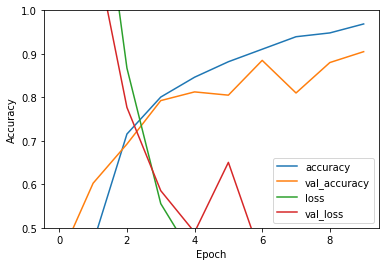

In [108]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')